In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import matplotlib.gridspec as gridspec
import matplotlib.pylab as plt
import numpy as np
import sklearn.neighbors as nn
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
from scipy.signal import gaussian, convolve
import time
from skimage import color

In [3]:
!pip install tensorflow-io

     |████████████████████████████████| 23.4 MB 1.6 MB/s 


In [4]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [5]:
import os
import time
import glob
import sys
import random
import warnings

import numpy as np
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt

import sklearn.neighbors as nn

from tqdm import tqdm
from itertools import chain
import skimage
from PIL import Image
from skimage.io import imread, imshow, imread_collection, concatenate_images,imsave
from skimage.transform import resize
from skimage.util import crop, pad
from skimage.morphology import label
from skimage.color import rgb2gray, gray2rgb, rgb2lab, lab2rgb
from sklearn.model_selection import train_test_split

import keras
from keras.applications.xception import Xception
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.models import Model, load_model,Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, UpSampling2D, RepeatVector, Reshape, BatchNormalization
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras.regularizers import l2

import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.python.client import device_lib
from tensorflow.python.ops.numpy_ops import np_config
        

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [6]:
class DatasetCleaner:
    
    '''
    Description : Class to Clean the Datasets
    '''

    # Method to remove the grayscale images from the directroy
    @staticmethod
    def removeGrayScaleFromDir(dirPath, osSep='/', fileType='*.jpg'):
        '''
        Description : 
                Method to remove any grayScale images from the directroy
        Input : 
                dirPath => Path to the image directory (dType - String)
                osSep => OS File Separator (dType - String | Defualt : backslash)
                fileType => Types of Images to read from the directory(dType - String | Default : '*.jpg') 	
        Returns : 
                List (Details of the files removed from the directory)
        '''

        print('Removing any grayScale Images from the directory.........')
        removedFileNames = []
        for id, fileName in enumerate(glob.glob(dirPath + osSep + fileType)):

            image = tf.io.read_file(fileName)
            image = tf.image.decode_jpeg(image)

            isGrayScale = True

            if len(image.shape) == 3 and image.shape[2] == 3:
                isGrayScale = False

            if isGrayScale:
                print(f'Removing ## ID : {id} ==== ImageShape : {image.shape} ==== FileName : {fileName}')
                removedFileNames.append([id, image.shape, fileName])
                os.remove(fileName)

        return removedFileNames

    
    # Method to remove the grayScale images from the numpy array
    @staticmethod
    def removeGrayScaleFromNumpy(numpyArr):
        '''
        Description : 
                Method to remove any grayScale images from the numpy.array
        Input : 
                numpyArr => numpy.array consisting of images
        Returns : 
                numpy.array (Consisting of only RGB images)
                List (Details of the images removed from the numpy)
        '''
        removedImages = []

        for id, image in enumerate(numpyArr):

            isGrayScale = True

            if len(image.shape) == 3 and image.shape[2] == 3:
                isGrayScale = False
                r = image[:,:,0]
                g = image[:,:,1]
                b = image[:,:,2]
                
                w = image.shape[0]
                h = image.shape[1]
                isGrayScale = False
                for i in range(w):
                    for j in range(h):
                        
                        if r[i,j] == g[i,j] == b[i,j]:
                            isGrayScale = True
                        else:
                            isGrayScale = False
                            break
            else:
                isGrayScale = True

            if isGrayScale:
                print(f'GrayScale Found ## ID : {id} ==== ImageShape : {image.shape}')
                removedImages.append([id, image.shape])
        print(removedImages)
        print('Removing any grayScale Images from the numpy.array.........')
        numpyArr = np.delete(numpyArr, [dtl[0] for dtl in removedImages], axis=0)

        return numpyArr, removedImages
    

In [7]:
filePath = '/content/drive/MyDrive/Datasets/GCScrapped/gc-dataset.zip'

In [8]:
!mkdir gcImages

In [ ]:
!unzip /content/drive/MyDrive/Datasets/GCScrapped/gc-dataset.zip -d /content/gcImages

In [82]:
dataset_path = '/content/gcImages/content/gc-dataset'
imgDirPath = '/content/gcImages/content/gc-dataset/train'
osSep = '/'
dataPath = imgDirPath + osSep + '*.jpg'
ptsFilePath = '/content/drive/MyDrive/Image Colorization/resources/pts291.npy'

In [83]:
imgSaveDirPath = '/content/drive/MyDrive/Image Colorization/resources/images/'
npyFileSaveDirPath = '/content/drive/MyDrive/Image Colorization/resources/'

In [11]:
rmFileList = DatasetCleaner.removeGrayScaleFromDir(imgDirPath)
print('-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-')
print(f'Total Count of the removed grayScale images : {len(rmFileList)}') 

Removing any grayScale Images from the directory.........
Removing ## ID : 174 ==== ImageShape : (256, 256, 1) ==== FileName : /content/gcImages/content/gc-dataset/train/5410.jpg
Removing ## ID : 722 ==== ImageShape : (256, 256, 1) ==== FileName : /content/gcImages/content/gc-dataset/train/1658.jpg
Removing ## ID : 1352 ==== ImageShape : (256, 256, 1) ==== FileName : /content/gcImages/content/gc-dataset/train/1204.jpg
Removing ## ID : 3007 ==== ImageShape : (256, 256, 1) ==== FileName : /content/gcImages/content/gc-dataset/train/8215.jpg
Removing ## ID : 3407 ==== ImageShape : (256, 256, 1) ==== FileName : /content/gcImages/content/gc-dataset/train/8689.jpg
Removing ## ID : 3471 ==== ImageShape : (256, 256, 1) ==== FileName : /content/gcImages/content/gc-dataset/train/7462.jpg
Removing ## ID : 4512 ==== ImageShape : (256, 256, 1) ==== FileName : /content/gcImages/content/gc-dataset/train/8679.jpg
Removing ## ID : 4952 ==== ImageShape : (256, 256, 1) ==== FileName : /content/gcImages/co

In [84]:
def load_data(size=64):
    image_folder = imgDirPath
    names = [f for f in os.listdir(image_folder) if f.lower().endswith('.jpg')]
    num_samples = len(os.listdir(imgDirPath))
    X_ab = np.empty((num_samples, size, size, 2))
    for i in range(num_samples):
        name = names[i]
        filename = os.path.join(image_folder, name)
        bgr = cv2.imread(filename)
        bgr = cv2.resize(bgr, (size, size), cv2.INTER_CUBIC)
        lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
        lab = lab.astype(np.int32)
        X_ab[i] = lab[:, :, 1:] - 128
    return X_ab

In [85]:
def compute_color_prior(X_ab, size=64, do_plot=False):
    # Load the gamut points location
    q_ab = np.load(ptsFilePath)

    if do_plot:
        #plt.figure(figsize=(15, 15))
        gs = gridspec.GridSpec(1, 1)
        ax = plt.subplot(gs[0])
        for i in range(q_ab.shape[0]):
            ax.scatter(q_ab[:, 1], q_ab[:, 0])
            ax.annotate(str(i), (q_ab[i, 1], q_ab[i, 0]), fontsize=6)
            ax.set_xlim([-110, 110])
            ax.set_ylim([-110, 110])

    npts, c, h, w = X_ab.shape
    X_a = np.ravel(X_ab[:, :, :, 0])
    X_b = np.ravel(X_ab[:, :, :, 1])
    X_ab = np.vstack((X_a, X_b)).T

    if do_plot:
        plt.hist2d(X_ab[:, 1], X_ab[:, 0], bins=100, density=True, norm=LogNorm())
        plt.xlim([-110, 110])
        plt.ylim([-110, 110])
        plt.gca().invert_yaxis()
        plt.colorbar()
        plt.savefig(imgSaveDirPath + 'compute_color_prior_hist2d_291.jpg')
        plt.show()

    # Create nearest neighbord instance with index = q_ab
    NN = 1
    nearest = nn.NearestNeighbors(n_neighbors=NN, algorithm='ball_tree').fit(q_ab)
    # Find index of nearest neighbor for X_ab
    dists, ind = nearest.kneighbors(X_ab)

    # We now count the number of occurrences of each color
    ind = np.ravel(ind)
    counts = np.bincount(ind)
    idxs = np.nonzero(counts)[0]
    prior_prob = np.zeros((q_ab.shape[0]))
    for i in range(q_ab.shape[0]):
        prior_prob[idxs] = counts[idxs]

    # We turn this into a color probability
    prior_prob = prior_prob / (1.0 * np.sum(prior_prob))

    # Save
    np.save(npyFileSaveDirPath + 'prior_prob_291.npy', prior_prob)

    if do_plot:
        plt.hist(prior_prob, bins=100)
        plt.yscale("log")
        plt.savefig(imgSaveDirPath + 'compute_color_prior_showhist_291.jpg')
        plt.show()

In [86]:
def smooth_color_prior(size=64, sigma=5, do_plot=False):
    prior_prob = np.load(npyFileSaveDirPath + 'prior_prob_291.npy')
    # add an epsilon to prior prob to avoid 0 vakues and possible NaN
    prior_prob += 1E-3 * np.min(prior_prob)
    # renormalize
    prior_prob = prior_prob / (1.0 * np.sum(prior_prob))

    # Smooth with gaussian
    f = interp1d(np.arange(prior_prob.shape[0]), prior_prob)
    xx = np.linspace(0, prior_prob.shape[0] - 1, 1000)
    yy = f(xx)
    window = gaussian(2000, sigma)  # 2000 pts in the window, sigma=5
    smoothed = convolve(yy, window / window.sum(), mode='same')
    fout = interp1d(xx, smoothed)
    prior_prob_smoothed = np.array([fout(i) for i in range(prior_prob.shape[0])])
    prior_prob_smoothed = prior_prob_smoothed / np.sum(prior_prob_smoothed)

    # Save
    file_name = npyFileSaveDirPath + 'prior_smoothed_prob_291.npy'
    np.save(file_name, prior_prob_smoothed)

    if do_plot:
        plt.plot(prior_prob)
        plt.plot(prior_prob_smoothed, "g--")
        plt.plot(xx, smoothed, "r-")
        plt.yscale("log")
        plt.savefig(imgSaveDirPath + 'smooth_color_prior_plot_291.jpg')
        plt.show()

In [87]:
def compute_prior_factor(size=64, gamma=0.5, alpha=1, do_plot=False):
    file_name = npyFileSaveDirPath + 'prior_smoothed_prob_291.npy'
    prior_prob_smoothed = np.load(file_name)

    u = np.ones_like(prior_prob_smoothed)
    u = u / np.sum(1.0 * u)

    prior_factor = (1 - gamma) * prior_prob_smoothed + gamma * u
    prior_factor = np.power(prior_factor, -alpha)

    # renormalize
    prior_factor = prior_factor / (np.sum(prior_factor * prior_prob_smoothed))

    file_name = npyFileSaveDirPath + 'prior_factor_291.npy'
    np.save(file_name, prior_factor)

    if do_plot:
        plt.plot(prior_factor)
        plt.yscale("log")
        plt.savefig(imgSaveDirPath + 'compute_prior_factor_plot_291.jpg')
        plt.show()

In [88]:
X_ab = load_data()

In [89]:
X_ab.shape

(8785, 64, 64, 2)

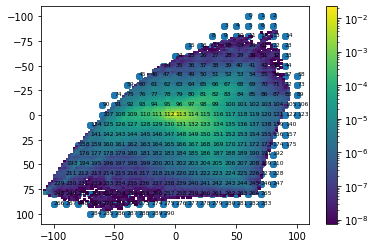

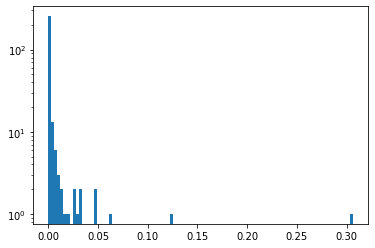

In [90]:
compute_color_prior(X_ab, do_plot=True)

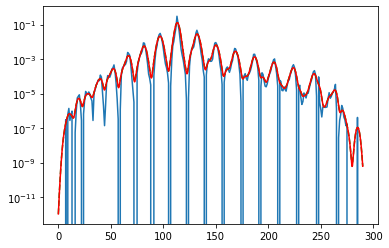

In [102]:
smooth_color_prior(do_plot=True)

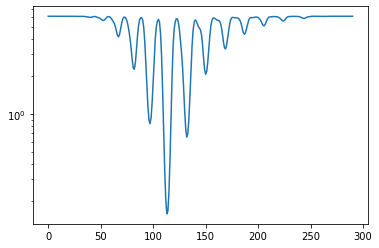

In [92]:
compute_prior_factor(do_plot=True)

In [93]:
prob = np.load(npyFileSaveDirPath + 'prior_prob_291.npy')

In [94]:
prob.shape

(291,)

In [95]:
smoothed = np.load(npyFileSaveDirPath + 'prior_smoothed_prob_291.npy')

In [96]:
smoothed.shape

(291,)

In [97]:
factor = np.load(npyFileSaveDirPath + 'prior_factor_291.npy')

In [98]:
factor.shape

(291,)

In [99]:
prob

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.05696855e-07,
       0.00000000e+00, 6.39184334e-07, 1.38953116e-06, 2.77906232e-07,
       5.83603088e-07, 9.72671813e-07, 0.00000000e+00, 0.00000000e+00,
       5.55812464e-08, 8.89299943e-07, 5.58591527e-06, 7.03102768e-06,
       8.55951195e-06, 2.38999360e-06, 2.77906232e-07, 0.00000000e+00,
       6.66974957e-07, 3.94626850e-06, 1.33950804e-05, 8.55951195e-06,
       9.83788062e-06, 1.25335711e-05, 9.58776501e-06, 5.39138090e-06,
       3.80731538e-06, 2.77906232e-07, 1.10328774e-05, 1.67855364e-05,
       2.95970137e-05, 4.36034878e-05, 6.20008804e-05, 5.57201996e-05,
       1.18916077e-04, 9.06808036e-05, 1.44233335e-05, 1.91755300e-06,
       1.38953116e-07, 2.11208736e-06, 4.42148815e-05, 1.11551562e-04,
       1.01018915e-04, 8.87354599e-05, 1.34534407e-04, 2.68568583e-04,
       3.14200786e-04, 4.62547133e-04, 1.83890554e-04, 4.11023317e-05,
      

In [100]:
smoothed

array([1.06474152e-12, 2.16765015e-11, 2.49225743e-10, 1.98046686e-09,
       1.00377194e-08, 3.50287012e-08, 8.97411984e-08, 1.87383532e-07,
       3.43167411e-07, 5.31445707e-07, 6.60659933e-07, 6.75636815e-07,
       6.09968477e-07, 5.01102534e-07, 3.92414595e-07, 4.71732113e-07,
       1.05110518e-06, 2.32812158e-06, 3.98466206e-06, 5.16062229e-06,
       5.08976762e-06, 3.80689457e-06, 2.32751887e-06, 1.80490637e-06,
       2.81947572e-06, 5.08617953e-06, 7.56219241e-06, 9.25753714e-06,
       9.94464832e-06, 9.75893080e-06, 8.61708767e-06, 6.93111762e-06,
       5.94306982e-06, 7.22216878e-06, 1.17454211e-05, 1.95975024e-05,
       3.01225141e-05, 4.25948737e-05, 5.60786887e-05, 6.83461128e-05,
       7.32565208e-05, 6.39104689e-05, 4.30345447e-05, 2.33234718e-05,
       1.64231198e-05, 2.57580070e-05, 4.81559223e-05, 7.42661103e-05,
       9.83718260e-05, 1.27067697e-04, 1.72019597e-04, 2.30108228e-04,
       2.75219753e-04, 2.72457769e-04, 2.13269972e-04, 1.27648313e-04,
      

In [101]:
factor

array([6.07107376, 6.07107372, 6.07107332, 6.07107026, 6.07105602,
       6.07101187, 6.07091522, 6.07074273, 6.07046755, 6.07013501,
       6.06990681, 6.06988036, 6.06999633, 6.0701886 , 6.07038056,
       6.07024047, 6.06921736, 6.06696349, 6.06404228, 6.06197025,
       6.06209505, 6.06435563, 6.06696455, 6.06788674, 6.06609672,
       6.06210137, 6.0577431 , 6.05476257, 6.05355542, 6.05388165,
       6.05588818, 6.05885332, 6.06059237, 6.05834124, 6.05039401,
       6.03664752, 6.01831927, 5.99674347, 5.97359133, 5.95268253,
       5.94435411, 5.9602258 , 5.99598571, 6.03014637, 6.04219732,
       6.0259061 , 5.98717326, 5.94264466, 5.90211852, 5.85459033,
       5.78165728, 5.69005891, 5.62090166, 5.62508751, 5.71631059,
       5.85363657, 5.96940656, 6.02629772, 6.02204512, 5.95471532,
       5.82826746, 5.66916345, 5.50154191, 5.29855298, 4.98608845,
       4.58111262, 4.24623532, 4.1519556 , 4.36269001, 4.82189579,
       5.35787629, 5.76079886, 5.95636637, 5.97737806, 5.85258